#### Load and split data

In [15]:
import numpy as np
import pandas as pd

In [16]:
with np.load('cifar4-train.npz',allow_pickle=False) as npz_file:
    data = dict(npz_file.items())
    print (data.keys())

dict_keys(['pixels', 'overfeat', 'labels', 'names', 'allow_pickle'])


In [77]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
    
# Create train set
X_train, X_test, y_train, y_test = train_test_split(data['overfeat'],data['labels'],test_size=1800, random_state=0)

# Create validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=1000, random_state=0)

print('Train:', X_train.shape, y_train.shape)
print('Valid:', X_valid.shape, y_valid.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (3200, 4096) (3200,)
Valid: (800, 4096) (800,)
Test: (1000, 4096) (1000,)


In [21]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

#### Create a multilayer network

In [1]:
import tensorflow as tf

In [110]:
#create a new graph
graph = tf.Graph()

with graph.as_default():
    #create placeholders
    X = tf.placeholder(dtype=tf.float32,shape=[None,4096])
    y = tf.placeholder(dtype=tf.int32,shape=[None])
    
    #hidden layer with 64 hidden units (ReLu)
    hidden = tf.layers.dense(X,64,activation=tf.nn.relu,kernel_initializer=tf.variance_scaling_initializer(scale=2,seed=0),
                            bias_initializer=tf.zeros_initializer(),name='hidden')
    
    #output layer
    logits = tf.layers.dense(hidden,4,activation=None,kernel_initializer=tf.variance_scaling_initializer(scale=1,seed=0),
                            bias_initializer=tf.zeros_initializer(),name='output') 
    
    # Get weights/biases of the hidden layer
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel')
        b1 = tf.get_variable('bias')

    # Get weights/biases of the output layer
    with tf.variable_scope('output', reuse=True):
        W2 = tf.get_variable('kernel')
        b2 = tf.get_variable('bias')

In [111]:
with graph.as_default():
    #create training placeholder
    training = tf.placeholder(dtype=tf.bool)
    
    #apply dropout (TO INPUTS AND HIDDEN UNITS)
    inputs = tf.layers.dropout(X,rate=0.5,seed=0.5,training=training)
    hidden = tf.layers.dropout(hidden,rate=0.5,seed=0.5,training=training) 
    
    #loss function cross entropy
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    
    #compute mean of cross entropy
    mean_ce = tf.reduce_mean(ce)
    
    #gradient descent
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)
    
    #L2 term FOR W1 AND W2
    l2_term_W1 = tf.nn.l2_loss(W1)
    l2_term_W2 = tf.nn.l2_loss(W2)
    
    #regularization strength
    alpha = tf.placeholder(dtype=tf.float32)
    
    #loss function
    loss = mean_ce + alpha * (l2_term_W1 + l2_term_W2)
        
    #training op
    train_op = gd.minimize(loss)
    
    #compute predictions and accuracy
    predictions = tf.argmax(logits,axis=1,output_type=tf.int32)
    is_correct = tf.equal(y,predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct,dtype=tf.float32))

#### Training the network
    

In [135]:
#validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    #initialize variables
    sess.run(tf.global_variables_initializer())
    
    #set seed
    np.random.seed(0)
    
    #train several epochs
    for epoch in range(150):
        #accuracy values (train) after each epoch
        epoch_acc = []
        
        #get batches of data
        for X_batch,y_batch in get_batches(X_train,y_train,260):
            _,acc_value = sess.run([train_op,accuracy],feed_dict={X:X_batch,y:y_batch,lr:0.001,training:True,alpha:0.001})
            epoch_acc.append(acc_value)
        
        #evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={X: X_valid,y: y_valid,training:False})
        valid_acc_values.append(valid_acc)
        
        #print progress
        #print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(epoch+1, valid_acc, np.mean(epoch_acc)))
    print ('Done')
    
    # Evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={X: X_test,y: y_test})
    print('Multilayer fully-connected network accuracy (test set): {:.3f}'.format(test_acc))   
    
    # Weights of the hidden layer
    weights_hidden = W1.eval()
    weights_hidden = W2.eval()

Done
Multilayer fully-connected network accuracy (test set): 0.805


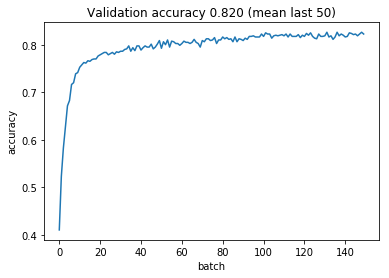

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy {:.3f} (mean last 50)'.format(np.mean(valid_acc_values[-50:])))
plt.xlabel('batch')
plt.ylabel('accuracy')
plt.show()